# Estimation of the Mean Function of Functional Data via Deep Neural Networks

In [92]:
# nibabel documentation: https://nipy.org/nibabel/gettingstarted.html
# https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20number%20of%20epochs%20is%20a%20hyperparameter%20that%20defines%20the,update%20the%20internal%20model%20parameters.

In [1]:
import glob
import pandas as pd
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, Dense, Dropout)
import nibabel as nib
from nibabel.testing import data_path

import pydot_ng
import pydot
import pydotplus
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', None)

# Data definition
- There are 69 images slices contained in a 3D data cube.
- We use one slice from a given cube.
- When combining with other slices from other images we need to make sure that we select the slice from the same position inside the cube.
- Each image slice is a 95x79 matrix.
- Each row of the matrix is the output vector which needs to be predicted. These are the individual pixels in the image.
- To predict the output we need to generate the features which are the coordinates of each pixel in the output vector.
- The coordinates need to be normalized to 1 so for each coordinate needs to be divided by the $L_0$ norm of the vector.
    - Example: for the first pixel the coordinates will be $(\frac{1}{95},\frac{1}{79})$ and for the last pixel the coordinates will be $(\frac{1}{95}, \frac{79}{79})$
-------------------------------------------------------

# Model input and output
## Input: a set of coordinates e.g. $(\frac{1}{95},\frac{1}{79})$

### X:
- Get all the first coordinates as first column of the input matrix
- Get all the second coordinates as the second column of the input matrix
----------------------------------------------------------
## Output: predicted value for the pixel at that coordinate.

### Y:
- Take the matrix that contains the actual pixels for each image (this is the desired output) and ravel the array to get it into a single array of 95*79 elements each corresponding to the pixel value that needs to be predicted.
    - example: for an image with dimensions 95x79 - the total number of coordinate sets should be 95*79
    - the number of coordinates should be exactly the same as the number of pixels in the image - this will give a 1:1 correspondence between coordinates and pixels
    - even though as the image changes the pixels in the image change - the coordinates will remain the same for each pixel.

In [1]:
%%writefile utils/preprocessing.py
import glob
import pandas as pd
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
import matplotlib.pyplot as plt

def get_mean_pixel_values(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=True, plot_mean_image_slice=True):
    """
    Take in images files. Combine the same slices and return mean pixel values.
    """
    pixel_values_by_slice = list()
    files = glob.glob(data_location)
    
    if num_images_to_use=='all':
        n = len(files)
    else:
        n = num_images_to_use
        
    for file in glob.glob(data_location)[:n]:
        images = nib.load(file) #load the data
        data = images.get_fdata().T #transpose the original data - it should fit the format 95*79
        if plot_image_slice:
            plt.imshow((data[img_slice]), cmap='gray')
            plt.title(file)
            plt.show()
        pixel_values_by_slice.append(data[img_slice])
    
    mean_pixel_values = np.array(pixel_values_by_slice).mean(axis=0)
    if plot_mean_image_slice:
        plt.imshow(mean_pixel_values, cmap='gray')
        plt.show()
    mean_pixel_values_flattened = mean_pixel_values.ravel()
    return mean_pixel_values, mean_pixel_values_flattened

def preprocess_image(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=True, plot_mean_image_slice=True):
    """
    Input: 
        img: Image as nii file - data cube with slices for an image
        img_slice: integer to specify which slice to select
    Return 
        X: dataframe with two columns containing X and Y coordinates.
        Y: flattened pixel values
    """
    pixel_values, pixel_values_flattened = get_mean_pixel_values(data_location=data_location,
                                                                 img_slice=img_slice,
                                                                 num_images_to_use=num_images_to_use,
                                                                 plot_image_slice=plot_image_slice,
                                                                 plot_mean_image_slice=plot_mean_image_slice)
    
    # Y = data[img_slice].ravel() #flatten the matrix of pixels into a single array
    Y = pd.DataFrame(pixel_values_flattened, columns=['pixel_value']) #for the first image
    
    #get the number of rows and columns for the matrix of pixels per image
    rows = pixel_values.shape[0] #number of rows
    cols = pixel_values.shape[1] #number of columns

    #generate coordinates
    row_indices = list()
    column_indices = list()

    row_coordinates =  (np.indices(dimensions=(rows, cols))[0]+1)*(1/rows) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize
    column_coordinates =  (np.indices(dimensions=(rows, cols))[1]+1)*(1/cols) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize

    for row in row_coordinates:
        for row_index in row:
            row_indices.append(row_index)

    for row in column_coordinates:
        for column_index in row:
            column_indices.append(column_index)
            
    X = pd.DataFrame(columns=['X_coordinate', 'Y_coordinate'])
    X['X_coordinate'] = np.array(row_indices)
    X['Y_coordinate'] = np.array(column_indices)
    
    return X, Y

def high_resolution_coordinates(num_rows=100, num_cols=100):
    """
    Input: 
        num_rows: pixel rows
        num_cols: pixel cols
    Return 
        X: dataframe with two columns containing X and Y coordinates.
        Y: flattened pixel values
    """
    
    #get the number of rows and columns for the matrix of pixels per image
    rows = num_rows #number of rows
    cols = num_cols #number of columns

    #generate coordinates
    row_indices = list()
    column_indices = list()

    row_coordinates =  (np.indices(dimensions=(rows, cols))[0]+1)*(1/rows) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize
    column_coordinates =  (np.indices(dimensions=(rows, cols))[1]+1)*(1/cols) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize

    for row in row_coordinates:
        for row_index in row:
            row_indices.append(row_index)

    for row in column_coordinates:
        for column_index in row:
            column_indices.append(column_index)
            
    X = pd.DataFrame(columns=['X_coordinate', 'Y_coordinate'])
    X['X_coordinate'] = np.array(row_indices)
    X['Y_coordinate'] = np.array(column_indices)
    
    return X

Overwriting utils/preprocessing.py


- Should coordinates and pixels values for all images be stacked and one combined dataset be created?

## Models

In [1]:
%%writefile models/mean_estimation_dnn_model.py
import pandas as pd
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, Activation, Dense)
import matplotlib.pyplot as plt

from utils.preprocessing import high_resolution_coordinates

class Callback(tf.keras.callbacks.Callback):
    epoch_controller = 25

    def on_epoch_end(self, epoch, logs=None):
        self.epoch = epoch
        if (self.epoch%self.epoch_controller==0):
            print('Epoch: ' + str(self.epoch) + ' loss: ' + str(logs['loss']))
        
def dnn_model(X_train, 
          Y_train, 
          num_layers=3,
          neurons_per_layer=1000,
          weight_initializer='standard_normal',
          activation_per_layer='relu',
          epochs=500, 
          loss='mse', 
          l1_regularizer=True,
          l1_penalty=1e-7,
          batch_size=4,
          verbose=0):
    """
    create and return the desired model
    """
    #regularizer
    if l1_regularizer:
        regularizer=tf.keras.regularizers.L1(l1=l1_penalty)
    else:
        regularizer=None
        
    #kernel initializers to initialize weights
    if weight_initializer=='standard_normal':
        initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1)
    if weight_initializer=='he_normal':
        initializer=tf.keras.initializers.HeNormal()
        
    # add max norm constraint
    max_norm = tf.keras.constraints.MaxNorm(max_value=2, axis=0)
        
    #model definition
    model = keras.models.Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    for n in range(num_layers):
        model.add(Dense(neurons_per_layer, 
                        kernel_initializer=initializer, 
                        kernel_regularizer=regularizer, 
                        kernel_constraint=max_norm,
                        activation=activation_per_layer))
    model.add(Dense(1))
    
            
    #define loss to minimize
    if loss=='huber':
        loss_to_minimize = tf.keras.losses.Huber() 
    elif loss=='mse':
        loss_to_minimize = tf.keras.losses.MeanSquaredError()
    
    #optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001, decay=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, 
        amsgrad=False, name='Adam'
    )
    
    #compile the model
    model.compile(loss=loss_to_minimize, 
                  optimizer=optimizer)
    
    #model fit
    model_history = model.fit(X_train, Y_train, 
                              batch_size=batch_size, 
                              epochs=epochs,  
                              callbacks=[Callback()], 
                              verbose=verbose)
    
    return model_history, model


def train_predict(X, Y, **model_params):
    """
    Train and predict pixel values from the model
    """
    num_layers = model_params["num_layers"] if "num_layers" in model_params else 3
    neurons_per_layer = model_params["neurons_per_layer"] if "neurons_per_layer" in model_params else 1000
    weight_initializer = model_params["weight_initializer"] if "weight_initializer" in model_params else "standard_normal"
    activation_per_layer = model_params["activation_per_layer"] if "activation_per_layer" in model_params else "relu"
    epochs = model_params["epochs"] if "epochs" in model_params else 500
    loss = model_params["loss"] if "loss" in model_params else "mse"
    l1_regularizer = model_params["l1_regularizer"] if "l1_regularizer" in model_params else True
    l1_penalty = model_params["l1_penalty"] if "l1_penalty" in model_params else 1e-7
    batch_size = model_params["batch_size"] if "batch_size" in model_params else 4
    verbose = model_params["verbose"] if "verbose" in model_params else 0
    get_high_resolution_image = model_params["get_high_resolution_image"] if "get_high_resolution_image" in model_params else False
    high_resolution_dimensions = model_params["high_resolution_dimensions"] if "high_resolution_dimensions" in model_params else (95,79)
    cmap = model_params["cmap"] if "cmap" in model_params else "gray"
    save_image_location_and_name = model_params["save_image_location_and_name"] if "save_image_location_and_name" else False
    
    model_history, model = dnn_model(X, Y,
                                     num_layers=num_layers,
                                     neurons_per_layer=neurons_per_layer,
                                     weight_initializer=weight_initializer,
                                     activation_per_layer=activation_per_layer, 
                                     epochs=epochs, 
                                     loss=loss, 
                                     l1_regularizer=l1_regularizer, 
                                     l1_penalty=l1_penalty,
                                     verbose=verbose)
    
    if get_high_resolution_image:
        num_rows, num_cols = high_resolution_dimensions
        X = high_resolution_coordinates(num_rows=num_rows, num_cols=num_cols)
        y_pred = model.predict(X)
        if save_image_location_and_name:
            plt.imshow(np.reshape(y_pred, (num_rows, num_rows)), cmap=cmap) #display the recovered image
            plt.savefig(save_image_location_and_name)
    else:
        y_pred = model.predict(X)
        default_dims = (50, 50)
        if save_image_location_and_name:
            plt.imshow(np.reshape(y_pred, (default_dims[0], default_dims[1])), cmap=cmap) #display the recovered image
            plt.savefig(save_image_location_and_name)
        
    return model_history, model, y_pred

Overwriting models/mean_estimation_dnn_model.py


Original Mean Image


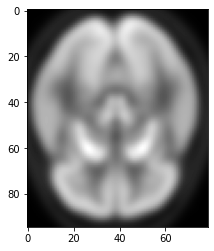

Epochs: 300, Activation: relu, Batch Size: 2
******************************
Epoch: 0 loss: 220.05149841308594
Epoch: 25 loss: 0.014325489290058613
Epoch: 50 loss: 0.004481685347855091
Epoch: 75 loss: 0.0025615552440285683
Epoch: 100 loss: 0.0015639499761164188
Epoch: 125 loss: 0.001183877931907773
Epoch: 150 loss: 0.0010295078391209245
Epoch: 175 loss: 0.000847698887810111
Epoch: 200 loss: 0.0007407826487906277
Epoch: 225 loss: 0.0006884660106152296
Epoch: 250 loss: 0.0006257729837670922
Epoch: 275 loss: 0.000590995536185801
High Resolution Image
******************************
Epochs: 300, Activation: relu, Batch Size: 4
******************************
Epoch: 0 loss: 78.47667694091797
Epoch: 25 loss: 0.015087027102708817
Epoch: 50 loss: 0.004820751957595348
Epoch: 75 loss: 0.002393815666437149
Epoch: 100 loss: 0.0015175056178122759
Epoch: 125 loss: 0.0011635343544185162
Epoch: 150 loss: 0.0009801913984119892
Epoch: 175 loss: 0.0007855893927626312
Epoch: 200 loss: 0.0007212584605440497
E

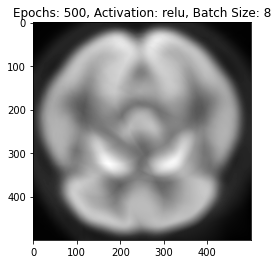

In [4]:
from collections import defaultdict

print('Original Mean Image')
X, Y = preprocess_image(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=False, plot_mean_image_slice=True)

# run for 300, 500 epochs each with batch size 2, 4, 6, 8
model_histories = defaultdict()
predictions = defaultdict()
for num_epochs in [300, 500]:
    for batch_size in [2, 4, 6, 8]:
        model_params = {"num_layers": 3,
                        "neurons_per_layer": 1000,
                        "weight_initializer": "standard_normal",
                        "activation_per_layer": "relu",
                        "epochs": num_epochs,
                        "loss": "mse",
                        "l1_regularizer": True,
                        "l1_penalty": 1e-7,
                        "batch_size": batch_size,
                        "verbose": 0}

        print(f'Epochs: {model_params["epochs"]}, Activation: {model_params["activation_per_layer"]}, Batch Size: {model_params["batch_size"]}')
        
        print('*'*30)
        model_history, model, y_pred = train_predict(X, Y, **model_params)
        model_histories[f'{model_params["epochs"]}-{model_params["activation_per_layer"]}-{model_params["batch_size"]}'] = pd.DataFrame(model_history.history)
        predictions[f'{model_params["epochs"]}-{model_params["activation_per_layer"]}-{model_params["batch_size"]}'] = y_pred
        
        plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray') #display the recovered image
        plt.title(f'Epochs: {model_params["epochs"]}, Activation: {model_params["activation_per_layer"]}, Batch Size: {model_params["batch_size"]}')
        plt.savefig(f'results/reconstructed_images/mean_estimation_dnn_images/{model_params["epochs"]}-{model_params["activation_per_layer"]}-{model_params["batch_size"]}.png')
        
        x_high_res_coordinates = high_resolution_coordinates(num_rows=500, num_cols=500)
        print("High Resolution Image")
        plt.imshow(np.reshape(model.predict(x_high_res_coordinates), (500, 500)), cmap='gray') #display the recovered image
        plt.title(f'Epochs: {model_params["epochs"]}, Activation: {model_params["activation_per_layer"]}, Batch Size: {model_params["batch_size"]}')
        plt.savefig(f'results/reconstructed_images/mean_estimation_dnn_images/high_res_images/{model_params["epochs"]}-{model_params["activation_per_layer"]}-{model_params["batch_size"]}.png')
        print('*'*30)
        

Epochs: 300, Activation: RELU, Batch Size: 2, Minimum Error: 0.0007
Epochs: 300, Activation: RELU, Batch Size: 4, Minimum Error: 0.0005
Epochs: 300, Activation: RELU, Batch Size: 6, Minimum Error: 0.0006
Epochs: 300, Activation: RELU, Batch Size: 8, Minimum Error: 0.0005
Epochs: 500, Activation: RELU, Batch Size: 2, Minimum Error: 0.0004
Epochs: 500, Activation: RELU, Batch Size: 4, Minimum Error: 0.0003
Epochs: 500, Activation: RELU, Batch Size: 6, Minimum Error: 0.0004
Epochs: 500, Activation: RELU, Batch Size: 8, Minimum Error: 0.0004


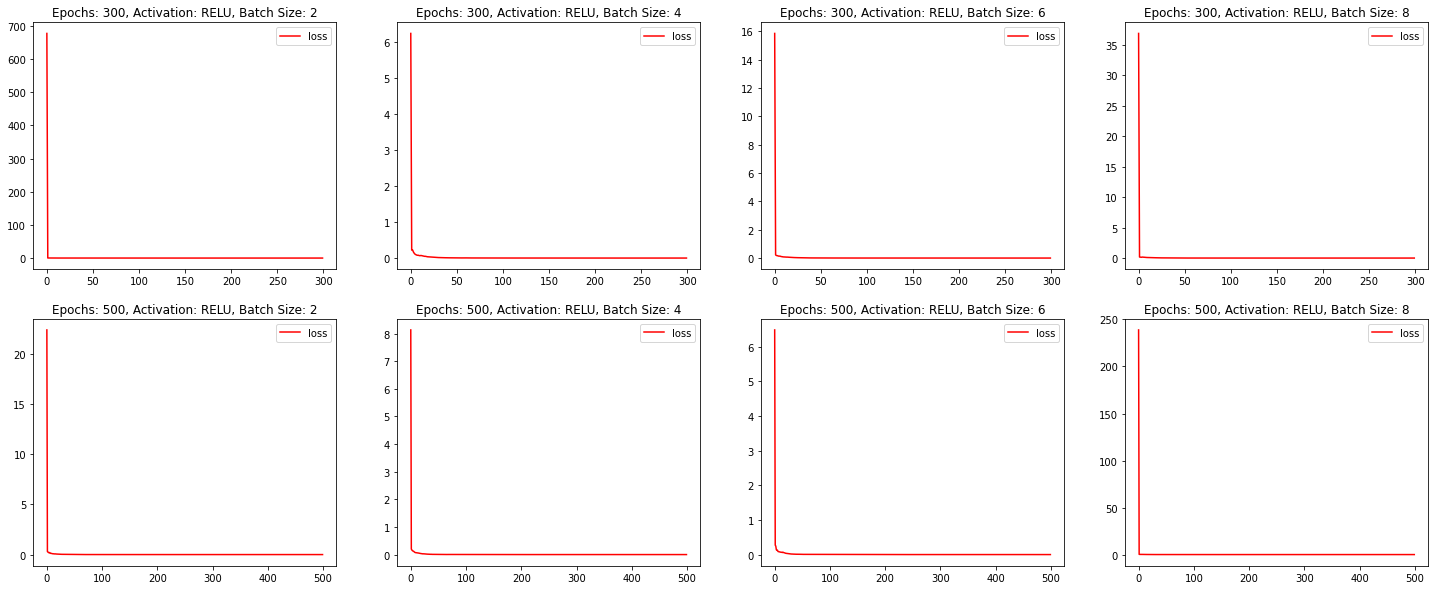

In [28]:
# keras.utils.plot_model(dnn_model)
iters = list(model_histories.keys())
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10))
for i, ax in zip(range(len(iters)), axs.ravel()):
    model_histories[iters[i]][:].plot(ax=ax, color='red')
    # ax.text(175, 5, f'Minimum Error: {round(model_histories[iters[i]].min()[0],4)}', fontsize=12)
    print(f'Epochs: {iters[i][:3]}, Activation: {iters[i][4:8].upper()}, Batch Size: {iters[i][9:]}, Minimum Error: {round(model_histories[iters[i]].min()[0],4)}')
    ax.set_title(f'Epochs: {iters[i][:3]}, Activation: {iters[i][4:8].upper()}, Batch Size: {iters[i][9:]}')
    plt.savefig('results/mean_estimation_dnn_all_errors.png', facecolor='white')